#  supervised anomaly detection

# What Is a Temporal Convolutional Network?

Temporal convolutional networks refer to a family of architectures that incorporate one-dimensional convolutional layers.

These convolutions are causal, meaning no information from the future is leaked into the past. In other words, the model only processes information going forward in time. 

Temporal convolutional networks don’t have this problem because they don’t rely on information from previous time steps, unlike recurrent neural networks, thanks to their casuality.

TCNs can map an input sequence of any length to an output sequence with the same length, just as a recurrent neural network (RNN) can do.

TCNs, the model might be required to remember varying levels of sequence history in order to make predictions. If the model did not have to take in as much history in the old task to make predictions, but in the new task it had to receive even more/less history to make predictions, that would cause issues
and might lead the model to perform poorly

In a one-dimensional convolutional layer, we still have parameter k to determine the size of our kernel, or filter. 

## Dilated Temporal Convolutional Network

Dilation Basically, when the dilation factor is greater than 1, we introduce gaps in the output data that correspond to the dilation factor. 

the spacing between each sampled entry has increased by one across all
directions. Vertically, horizontally, and diagonally, the sampled entries are all spaced apart by one entry. Essentially, this spacing is determined by finding what d – 1 is, where d is the dilation factor.

the difference between an acausal and a casual dilated convolution.

### acausal network

The first hidden layer has a dilation factor of two, and the second hidden layer has a dilation factor of four. Notice how inputs “forward in the sequence” contribute to the next layer’s node as well

### causal network

In a casual network, we only want information that we’ve learned up until the
present, so none of the information from the future will be accounted for in the model’s predictions.

The first hidden layer has a dilation factor of two, and the second hidden layer has a dilation factor of four. Notice how no inputs forward in the sequence contribute to the next layer’s node. This type of structure is ideal if the goal is to preserve some sort of flow within the data set, which is time in our case

# Library

In [1]:
from tensorflow.keras import optimizers
from tensorflow.keras import losses
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, Input, Dropout, Embedding, LSTM
from tensorflow.keras.optimizers import RMSprop, Adam, Nadam
from tensorflow.keras.preprocessing import sequence
from tensorflow.keras.callbacks import TensorBoard
from tensorflow.keras import regularizers

In [2]:
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, roc_auc_score
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import classification_report

In [6]:
import seaborn as sns
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

In [4]:
%load_ext autoreload
%autoreload 2

import sys
sys.path.append(f'E:\gitlab\custom-script\script')
from ursar import describe,scoring,fe,anomaly_detection

%reload_ext autoreload

# Load data

In [5]:
filePath = f'E:/gitlab/machine-learning/dataset/creditcard.csv'
df = pd.read_csv(filepath_or_buffer=filePath, header=0, sep=',')
print(df.shape[0])
df.head()

284807


,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


In [7]:
df['Amount'] = StandardScaler().fit_transform(df['Amount'].values.reshape(-1, 1))
df['Time'] = StandardScaler().fit_transform(df['Time'].values.reshape(-1, 1))
anomalies = df[df["Class"] == 1]
normal = df[df["Class"] == 0]

In [8]:
describe.describe_data(df)

'table size 284807 x 31'

Dataframe has 31 columns.
There are 0 columns that have missing values.


,column_names,Data Type,Missing Values,% missing,low Value,Hi Value,stddev Value,unique
0,Time,float64,0,0.0,-2,2,1,124592.0
1,V1,float64,0,0.0,-56,2,2,275663.0
2,V2,float64,0,0.0,-73,22,2,275663.0
3,V3,float64,0,0.0,-48,9,2,275663.0
4,V4,float64,0,0.0,-6,17,1,275663.0
5,V5,float64,0,0.0,-114,35,1,275663.0
6,V6,float64,0,0.0,-26,73,1,275663.0
7,V7,float64,0,0.0,-44,121,1,275663.0
8,V8,float64,0,0.0,-73,20,1,275663.0
9,V9,float64,0,0.0,-13,16,1,275663.0


# split data

In [24]:
for f in range(0, 20):
    normal = normal.iloc[np.random.permutation(len(normal))]
    
data_set = pd.concat([normal[:2000], anomalies])

x_train, x_test = train_test_split(data_set, test_size = 0.4, random_state = 42)

x_train = x_train.sort_values(by=['Time'])
x_test = x_test.sort_values(by=['Time'])

y_train = x_train["Class"]
y_test = x_test["Class"]

x_train.head(10)

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
154,-1.994583,1.195572,0.258858,0.635796,0.641257,-0.395081,-0.694667,0.034086,-0.124346,-0.078400,...,-0.201249,-0.516925,0.199096,0.412552,0.122984,0.101940,-0.007846,0.020214,-0.348072,0
623,-1.986644,-3.043541,-3.157307,1.088463,2.288644,1.359805,-1.064823,0.325574,-0.067794,-0.270953,...,0.661696,0.435477,1.375966,-0.293803,0.279798,-0.145362,-0.252773,0.035764,1.761758,1
844,-1.983043,-1.740943,0.328033,1.351311,-1.843991,-0.993856,0.377589,-1.153172,1.259231,-1.504410,...,0.634699,1.564409,-0.110073,-0.222538,0.023704,-0.152348,0.034025,-0.060339,-0.297296,0
1535,-1.971229,1.274773,-0.472615,-0.856227,-2.289194,0.057619,-0.662495,0.286438,-0.270717,1.426729,...,0.016321,0.252698,-0.446348,-0.744420,1.160347,-0.614472,0.038274,0.001193,-0.092154,0
1569,-1.970724,-0.693097,0.720897,0.487926,1.545283,-0.123343,0.151906,1.821822,-0.176592,-1.514396,...,0.200782,0.193611,0.288196,-0.081502,0.281742,-0.136080,0.050083,0.147487,0.765955,0
1576,-1.970661,-0.551876,1.261348,1.922560,2.622323,0.596227,1.669259,0.185452,0.659506,-1.347178,...,-0.067505,0.001192,0.171345,-0.692504,-0.803838,0.070919,0.447613,0.188936,-0.350231,0
1873,-1.966196,1.076700,0.136319,1.459568,2.754205,-0.642823,0.681681,-0.643585,0.354309,0.325720,...,-0.182605,-0.302743,0.103533,0.054746,0.225552,-0.059311,0.055243,0.028815,-0.353229,0
2029,-1.963459,-1.607192,1.388355,-0.608561,-1.824928,1.987696,3.560317,-0.488540,0.645383,0.265339,...,0.489407,-0.967222,-0.016906,1.011501,0.316639,0.410541,0.407710,0.222759,-0.333239,0
2405,-1.955204,-0.719146,0.783813,1.775893,0.079051,0.343203,-0.114907,0.822626,-0.171001,0.054662,...,-0.187615,-0.084469,-0.160515,0.132860,-0.101045,0.225809,0.047634,-0.043690,-0.273188,0
2446,-1.954193,-1.137545,1.565642,1.286361,-0.071602,-0.064120,-0.830399,0.817646,-0.193387,0.362810,...,-0.330126,-0.522862,0.082999,0.541690,-0.188973,0.041419,0.276674,0.074802,-0.317287,0


To pass the data sets into the model, the x sets must be three-dimensional, and the y sets must be two-dimensional. You can simply reshape the x sets, and change the y sets to be categorical 

In [25]:
TCN,x_train,x_test,y_train,y_test = anomaly_detection.model_tcn(x_train,x_test,y_train,y_test)

Shapes:
x_train:(1495, 31, 1)
y_train:(1495, 2)

x_test:(997, 31, 1)
y_test:(997, 2)

input_shape:(31, 1)



Model: "model_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_7 (InputLayer)         [(None, 31, 1)]           0         
_________________________________________________________________
conv1d_24 (Conv1D)           (None, 31, 128)           384       
_________________________________________________________________
spatial_dropout1d_24 (Spatia (None, 31, 128)           0         
_________________________________________________________________
conv1d_25 (Conv1D)           (None, 31, 128)           32896     
_________________________________________________________________
spatial_dropout1d_25 (Spatia (None, 31, 128)           0         
_________________________________________________________________
conv1d_26 (Conv1D)           (None, 31, 128)           32896     
________________

In [26]:
name = 'tcn'
tensorboard = TensorBoard(log_dir="logs/{}".format(name),profile_batch = 1000)

TCN.fit(x_train, y_train,
          batch_size=128,
          epochs=10,
          verbose=1,
          validation_data=(x_test, y_test),
          callbacks = [tensorboard])

Train on 1495 samples, validate on 997 samples
Epoch 1/10
1495/1495 [==============================] - 2s 2ms/sample - loss: 6.8329 - mae: 0.3025 - accuracy: 0.8896 - val_loss: 4.4037 - val_mae: 0.1250 - val_accuracy: 0.9599
Epoch 2/10
1495/1495 [==============================] - 0s 211us/sample - loss: 3.1219 - mae: 0.0930 - accuracy: 0.9639 - val_loss: 1.8682 - val_mae: 0.0992 - val_accuracy: 0.9579
Epoch 3/10
1495/1495 [==============================] - 0s 184us/sample - loss: 1.2615 - mae: 0.1056 - accuracy: 0.9632 - val_loss: 0.7056 - val_mae: 0.1138 - val_accuracy: 0.9579
Epoch 4/10
1495/1495 [==============================] - 0s 182us/sample - loss: 0.4629 - mae: 0.1082 - accuracy: 0.9612 - val_loss: 0.2581 - val_mae: 0.0919 - val_accuracy: 0.9519
Epoch 5/10
1495/1495 [==============================] - 0s 168us/sample - loss: 0.1736 - mae: 0.0937 - accuracy: 0.9592 - val_loss: 0.1136 - val_mae: 0.0803 - val_accuracy: 0.9529
Epoch 6/10
1495/1495 [==============================] -

# evaluate

In [36]:
score = TCN.evaluate(x_test, y_test, verbose=1)
print('Test loss:', score[0])
print('Test mae:', score[1])
print('Test accuracy:', score[2])

997/997 [==============================] - 0s 113us/sample - loss: 0.0542 - mae: 0.0875 - accuracy: 0.9609
Test loss: 0.05421905995812734
Test mae: 0.0875485
Test accuracy: 0.96088266


In [29]:
from sklearn.metrics import roc_auc_score

preds = TCN.predict(x_test)
y_pred = np.round(preds)
auc = roc_auc_score( y_pred, y_test)
print("AUC: {:.2%}".format (auc))

AUC: 97.42%


In [30]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.95      1.00      0.98       799
           1       0.99      0.81      0.89       198

   micro avg       0.96      0.96      0.96       997
   macro avg       0.97      0.90      0.93       997
weighted avg       0.96      0.96      0.96       997
 samples avg       0.96      0.96      0.96       997



In [34]:
y_pred2 = np.argmax(y_pred, axis=1)
y_test2 = np.argmax(y_test, axis=1)

comfusion matrix = 
[[798   1]
 [ 38 160]]

accuracy_score =  0.9609
balanced_accuracy_score =  0.9034

precision score =  0.9938
average precision score =  0.8412
recall score =  0.8081

F1 score =  0.8914
F2 score =  0.9501
F3 score =  0.9715
F_beta score =  0.9715
Matthews Correlation Coefficient score =  0.8747

AUC of Precision-Recall Curve on Testing =  0.92
Best Threshold for Precision-Recall Curve = 1.000000
F-Score = 0.891
AUC of ROC =  0.9034

Best Threshold for ROC = 1.000000
G-Mean = 0.898
Best Threshold with Youden’s J statistic = 1.000000

Cohens kappa =  0.8678
Gini =  0.84

Expected Approval Rate =  0.1615
Expected Default Rate =  0.0062

classification_report
              precision    recall  f1-score   support

           0       0.95      1.00      0.98       799
           1       0.99      0.81      0.89       198

    accuracy                           0.96       997
   macro avg       0.97      0.90      0.93       997
weighted avg       0.96      0.96      0.96

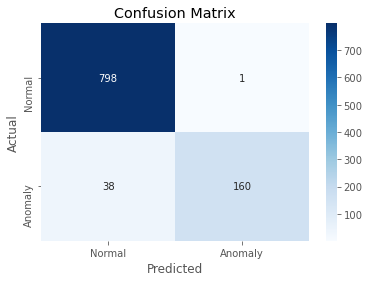

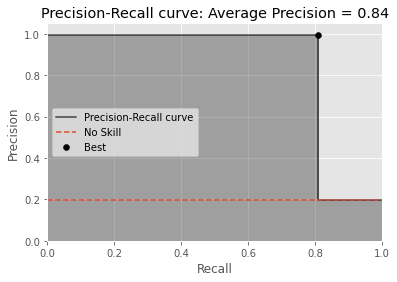

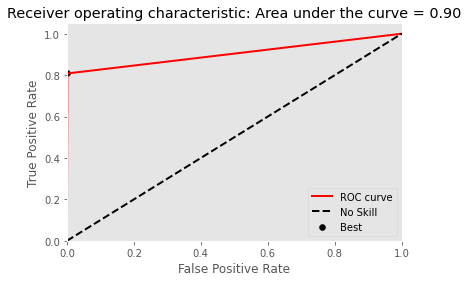


time span=  1


In [35]:
scoring.print_score(y_test2,y_pred2,y_pred2,labels=["Normal", "Anomaly"])